In [ ]:
# Part 1: Data Loading and Basic Preprocessing

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv('AirData.csv')

# Drop unique identifier column
df = df.drop(columns=['Accident_ID'])

# Display basic info
print("Dataset Info:\n", df.info())
print("\nMissing values:\n", df.isnull().sum())


# Assume the target variable is named 'Severity' (modify if needed)
target_column = 'Severity'
X = df.drop(columns=[target_column])
y = df[target_column]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   #x-input y-target

print("\nTrain-Test split completed.")
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Severity                 10000 non-null  object 
 1   Safety_Score             10000 non-null  float64
 2   Days_Since_Inspection    10000 non-null  int64  
 3   Total_Safety_Complaints  10000 non-null  int64  
 4   Control_Metric           10000 non-null  float64
 5   Turbulence_In_gforces    10000 non-null  float64
 6   Cabin_Temperature        10000 non-null  float64
 7   Accident_Type_Code       10000 non-null  int64  
 8   Max_Elevation            10000 non-null  float64
 9   Violations               10000 non-null  int64  
 10  Adverse_Weather_Metric   10000 non-null  float64
dtypes: float64(6), int64(4), object(1)
memory usage: 859.5+ KB
Dataset Info:
 None

Missing values:
 Severity                   0
Safety_Score               0
Days_Since_Inspection      0
T


Summary Statistics:
       Safety_Score  Days_Since_Inspection  Total_Safety_Complaints  \
count  10000.000000           10000.000000             10000.000000   
mean      41.876406              12.931100                 6.564300   
std       16.138072               3.539803                 6.971982   
min        0.000000               1.000000                 0.000000   
25%       30.593607              11.000000                 2.000000   
50%       41.278539              13.000000                 4.000000   
75%       52.511416              15.000000                 9.000000   
max      100.000000              23.000000                54.000000   

       Control_Metric  Turbulence_In_gforces  Cabin_Temperature  \
count    10000.000000           10000.000000       10000.000000   
mean        65.145324               0.381495          79.969331   
std         11.882934               0.121301           2.759739   
min          0.000000               0.134000          74.740000   
25% 

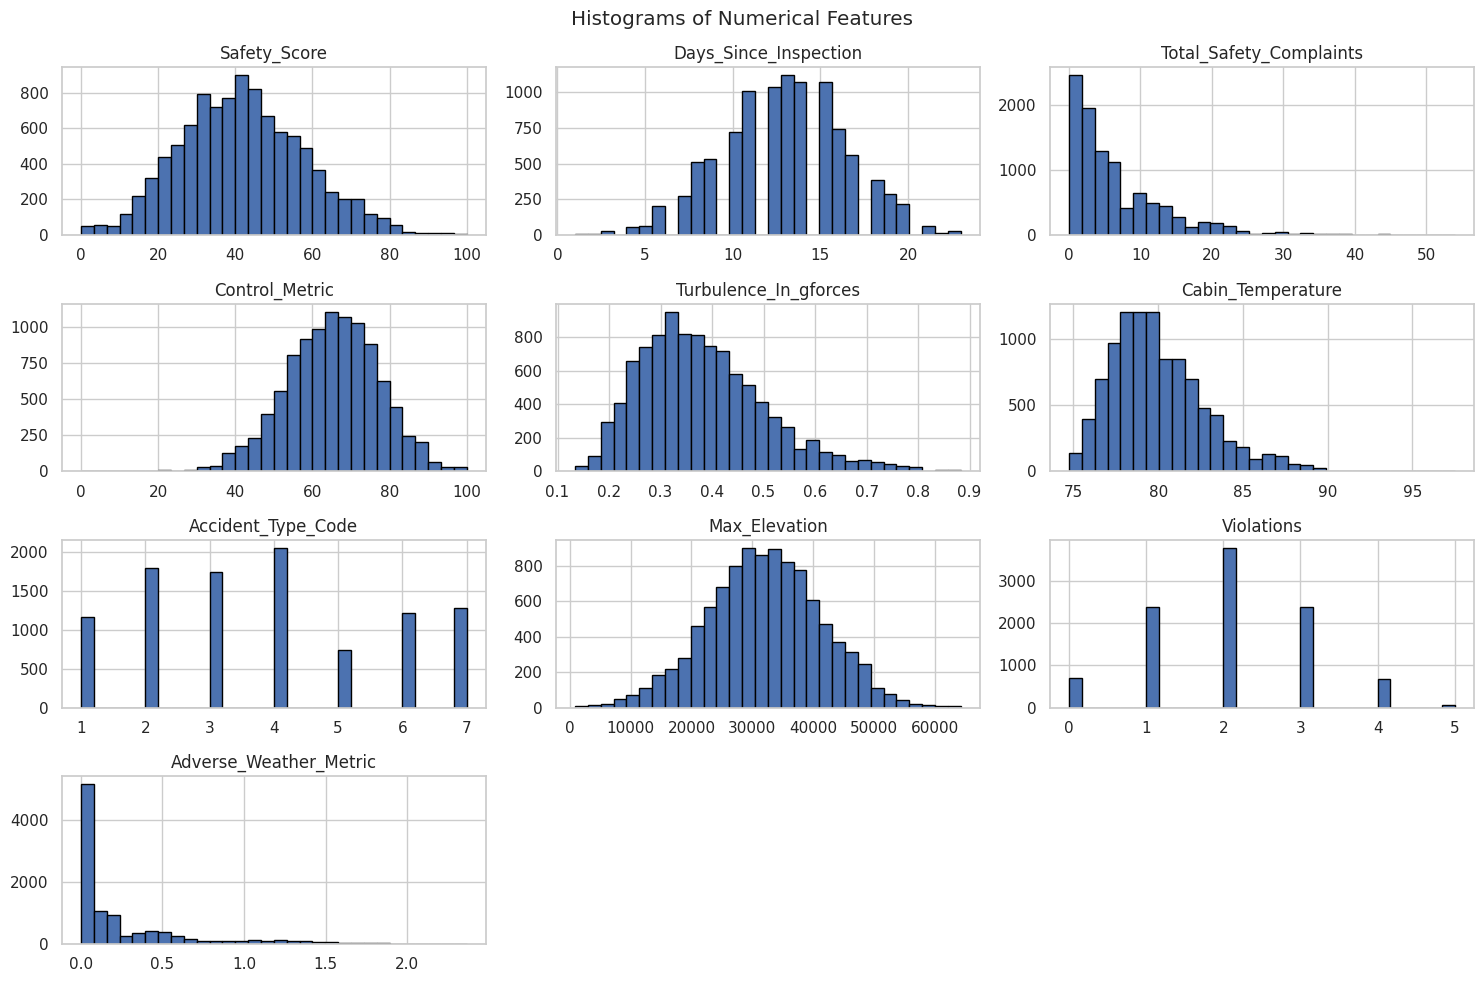

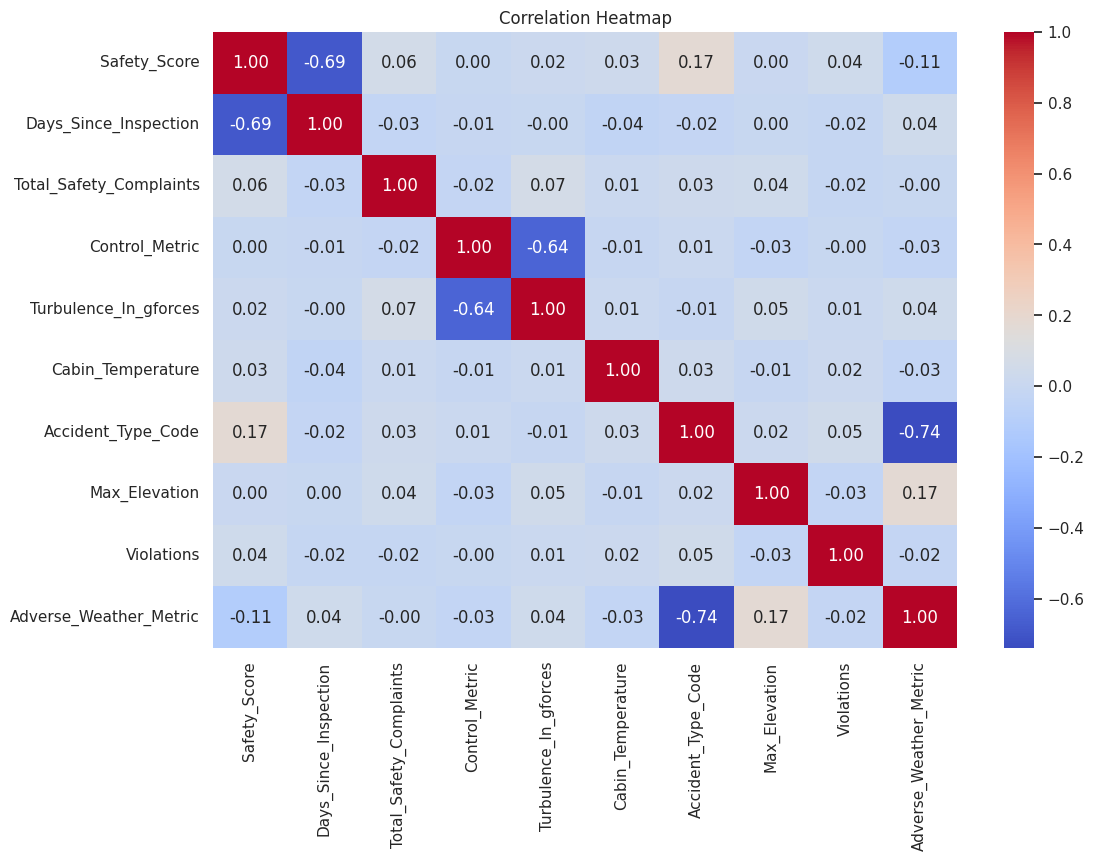

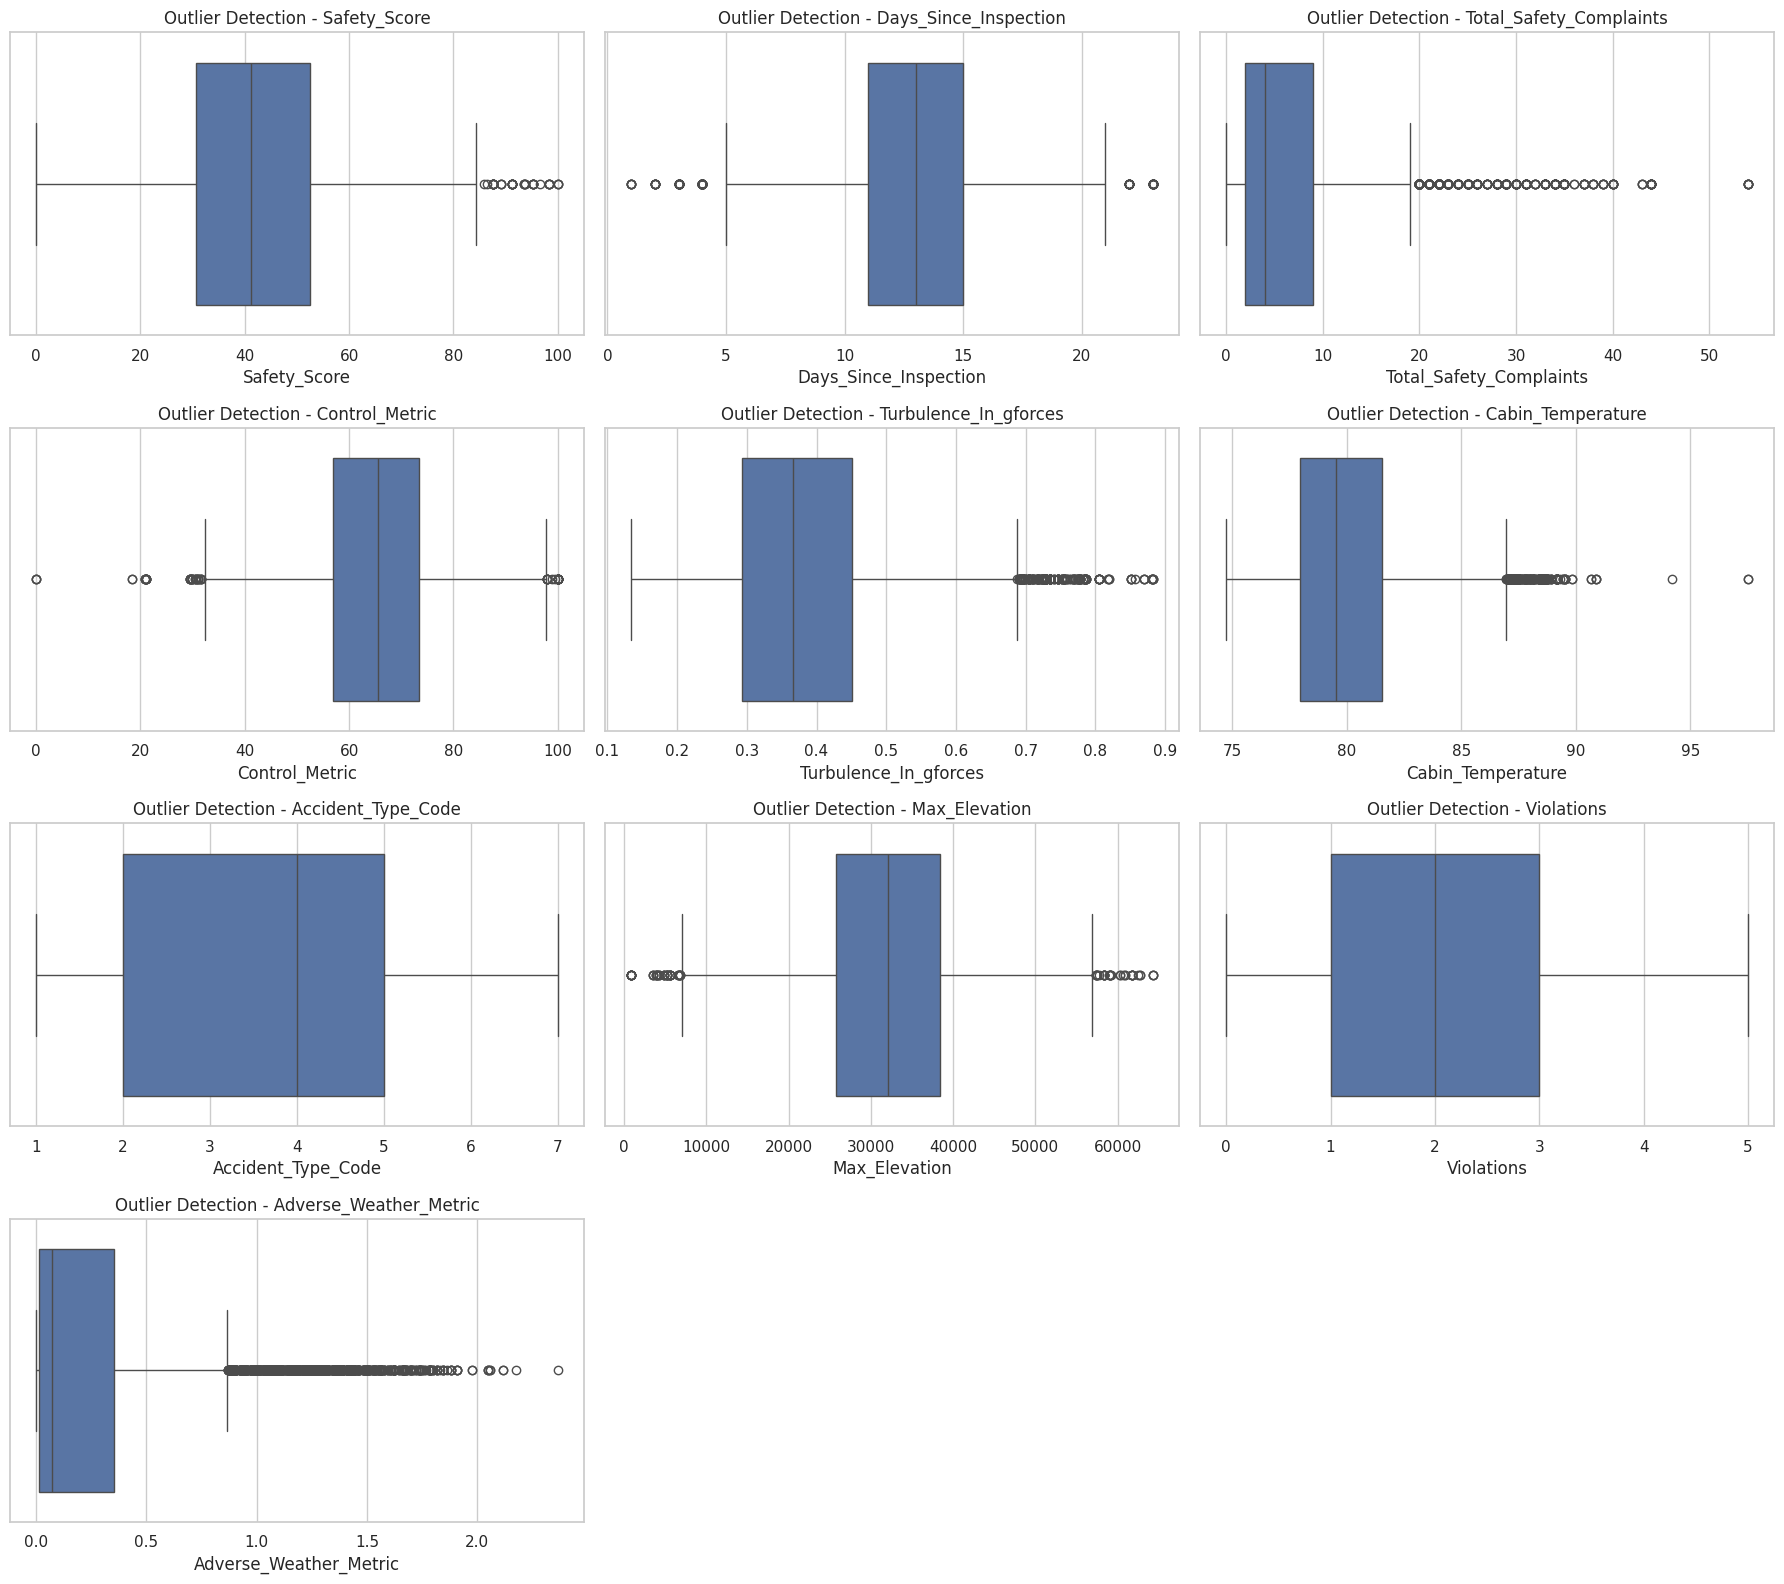

Original shape: (10000, 11)
Shape after outlier removal: (7928, 11)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Set style
sns.set(style="whitegrid")

# Show basic info
print("\nSummary Statistics:")
print(df.describe())

# 1. Distribution of numerical features
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

df[numerical_cols].hist(figsize=(15, 10), bins=30, edgecolor='black')
plt.suptitle("Histograms of Numerical Features")
plt.tight_layout()
plt.show()

# 2. Correlation heatmap
plt.figure(figsize=(12, 8))
corr_matrix = df[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# 3. Group and compare categories (example: using 'Accident_Severity' if it exists)
if 'Accident_Severity' in df.columns:
    for col in numerical_cols:
        plt.figure(figsize=(6, 4))
        sns.boxplot(x='Accident_Severity', y=col, data=df)
        plt.title(f'{col} by Accident Severity')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Grid size: 3 columns
n_cols = 3
n_rows = math.ceil(len(numerical_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()  # Make it 1D array for easier indexing

for i, col in enumerate(numerical_cols):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f'Outlier Detection - {col}')
    axes[i].set_xlabel(col)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Create a copy to avoid modifying original data
df_cleaned = df.copy()

# Loop through all numerical columns
for col in numerical_cols:
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove outliers
    df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]

print(f"Original shape: {df.shape}")
print(f"Shape after outlier removal: {df_cleaned.shape}")


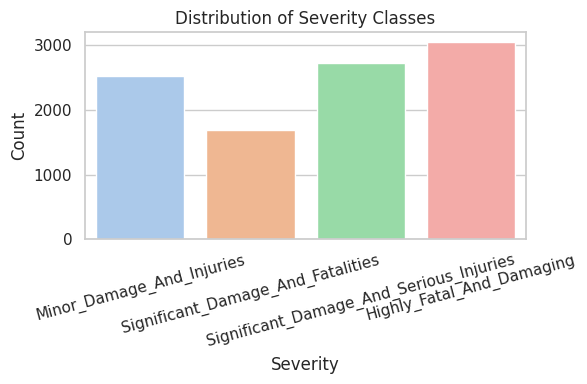

In [ ]:
# Plot count of each Severity class
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Severity', hue='Severity', palette='pastel', legend=False)
plt.title("Distribution of Severity Classes")
plt.xlabel("Severity")
plt.ylabel("Count")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


In [ ]:
# Part 3: Ordinal Logistic Regression (OLR)

import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Make sure target is ordinal (int-encoded) and sorted
# Example: 0 = Low, 1 = Medium, 2 = High

# Initialize and fit LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

unique_classes = sorted(y_train.unique())
print("Unique Severity Levels:", unique_classes)
print("Encoded Severity Levels:", sorted(np.unique(y_train_encoded)))

# Fit Ordered Logistic Regression
olr_model = OrderedModel(
    y_train_encoded,  # Use encoded target variable
    X_train, # Use features without adding a constant term
    distr='logit'  # 'probit' is also supported
)

olr_result = olr_model.fit(method='bfgs', disp=False)

# Predict class probabilities and choose the class with max probability
pred_probs = olr_result.predict(X_test) # Use test features without adding a constant term
y_pred_olr = np.argmax(pred_probs.values, axis=1)

# Evaluation
print("\n🔹 Ordinal Logistic Regression (OLR) Results:")
print("Accuracy:", accuracy_score(y_test_encoded, y_pred_olr))
print("Confusion Matrix:\n", confusion_matrix(y_test_encoded, y_pred_olr))
print("Classification Report:\n", classification_report(y_test_encoded, y_pred_olr))

Unique Severity Levels: ['Highly_Fatal_And_Damaging', 'Minor_Damage_And_Injuries', 'Significant_Damage_And_Fatalities', 'Significant_Damage_And_Serious_Injuries']
Encoded Severity Levels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]

🔹 Ordinal Logistic Regression (OLR) Results:
Accuracy: 0.34
Confusion Matrix:
 [[500  10   0  87]
 [186  73   0 234]
 [160   1   0 166]
 [416  60   0 107]]
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.84      0.54       597
           1       0.51      0.15      0.23       493
           2       0.00      0.00      0.00       327
           3       0.18      0.18      0.18       583

    accuracy                           0.34      2000
   macro avg       0.27      0.29      0.24      2000
weighted avg       0.30      0.34      0.27      2000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Part 4: K-Nearest Neighbors (KNN)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize KNN
knn_model = KNeighborsClassifier(n_neighbors=5)  # KNN model object created and stored  in the variable -You can tune this later

# Train the model
knn_model.fit(X_train, y_train)

# Predict
y_pred_knn = knn_model.predict(X_test)

# Evaluation
print("\n🔹 K-Nearest Neighbors (KNN) Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))


🔹 K-Nearest Neighbors (KNN) Results:
Accuracy: 0.444
Confusion Matrix:
 [[361 106  37  93]
 [121 226  49  97]
 [101  99  91  36]
 [190 153  30 210]]
Classification Report:
                                          precision    recall  f1-score   support

              Highly_Fatal_And_Damaging       0.47      0.60      0.53       597
              Minor_Damage_And_Injuries       0.39      0.46      0.42       493
      Significant_Damage_And_Fatalities       0.44      0.28      0.34       327
Significant_Damage_And_Serious_Injuries       0.48      0.36      0.41       583

                               accuracy                           0.44      2000
                              macro avg       0.44      0.43      0.42      2000
                           weighted avg       0.45      0.44      0.44      2000



In [ ]:
# Part 5: Support Vector Machine (SVM)

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize the SVM classifier (default is RBF kernel)
svm_model = SVC(kernel='rbf', C=1.0)

# Train the model
svm_model.fit(X_train, y_train)

# Predict
y_pred_svm = svm_model.predict(X_test)

# Evaluation
print("\n🔹 Support Vector Machine (SVM) Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))



🔹 Support Vector Machine (SVM) Results:
Accuracy: 0.2985
Confusion Matrix:
 [[597   0   0   0]
 [493   0   0   0]
 [327   0   0   0]
 [583   0   0   0]]
Classification Report:
                                          precision    recall  f1-score   support

              Highly_Fatal_And_Damaging       0.30      1.00      0.46       597
              Minor_Damage_And_Injuries       0.00      0.00      0.00       493
      Significant_Damage_And_Fatalities       0.00      0.00      0.00       327
Significant_Damage_And_Serious_Injuries       0.00      0.00      0.00       583

                               accuracy                           0.30      2000
                              macro avg       0.07      0.25      0.11      2000
                           weighted avg       0.09      0.30      0.14      2000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Part 6: Decision Tree Classifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize the model
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model
dt_model.fit(X_train, y_train)

# Predict
y_pred_dt = dt_model.predict(X_test)

# Evaluation
print("\n🔹 Decision Tree Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))
print("Classification Report:\n", classification_report(y_test, y_pred_dt))



🔹 Decision Tree Results:
Accuracy: 0.9195
Confusion Matrix:
 [[550  18   9  20]
 [ 10 456   7  20]
 [ 13  14 293   7]
 [ 16  23   4 540]]
Classification Report:
                                          precision    recall  f1-score   support

              Highly_Fatal_And_Damaging       0.93      0.92      0.93       597
              Minor_Damage_And_Injuries       0.89      0.92      0.91       493
      Significant_Damage_And_Fatalities       0.94      0.90      0.92       327
Significant_Damage_And_Serious_Injuries       0.92      0.93      0.92       583

                               accuracy                           0.92      2000
                              macro avg       0.92      0.92      0.92      2000
                           weighted avg       0.92      0.92      0.92      2000



In [ ]:
# Part 7: Naïve Bayes Classifier

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize model
nb_model = GaussianNB()

# Train the model
nb_model.fit(X_train, y_train)

# Predict
y_pred_nb = nb_model.predict(X_test)

# Evaluation
print("\n🔹 Naïve Bayes Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))



🔹 Naïve Bayes Results:
Accuracy: 0.475
Confusion Matrix:
 [[340  94  21 142]
 [100 236  24 133]
 [118  50  77  82]
 [169  70  47 297]]
Classification Report:
                                          precision    recall  f1-score   support

              Highly_Fatal_And_Damaging       0.47      0.57      0.51       597
              Minor_Damage_And_Injuries       0.52      0.48      0.50       493
      Significant_Damage_And_Fatalities       0.46      0.24      0.31       327
Significant_Damage_And_Serious_Injuries       0.45      0.51      0.48       583

                               accuracy                           0.47      2000
                              macro avg       0.48      0.45      0.45      2000
                           weighted avg       0.48      0.47      0.47      2000



In [ ]:
# Part 8: Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("\n🔹 Random Forest Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))



🔹 Random Forest Results:
Accuracy: 0.934
Confusion Matrix:
 [[555  18  12  12]
 [  7 470   5  11]
 [  4  17 299   7]
 [ 14  22   3 544]]
Classification Report:
                                          precision    recall  f1-score   support

              Highly_Fatal_And_Damaging       0.96      0.93      0.94       597
              Minor_Damage_And_Injuries       0.89      0.95      0.92       493
      Significant_Damage_And_Fatalities       0.94      0.91      0.93       327
Significant_Damage_And_Serious_Injuries       0.95      0.93      0.94       583

                               accuracy                           0.93      2000
                              macro avg       0.93      0.93      0.93      2000
                           weighted avg       0.93      0.93      0.93      2000



In [ ]:
# Part 9: AdaBoost Classifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize the model
ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)

# Train the model
ada_model.fit(X_train, y_train)

# Predict
y_pred_ada = ada_model.predict(X_test)

# Evaluation
print("\n🔹 AdaBoost Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_ada))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ada))
print("Classification Report:\n", classification_report(y_test, y_pred_ada))



🔹 AdaBoost Results:
Accuracy: 0.5605
Confusion Matrix:
 [[446  68  34  49]
 [ 97 247  19 130]
 [148  36  21 122]
 [ 86  39  51 407]]
Classification Report:
                                          precision    recall  f1-score   support

              Highly_Fatal_And_Damaging       0.57      0.75      0.65       597
              Minor_Damage_And_Injuries       0.63      0.50      0.56       493
      Significant_Damage_And_Fatalities       0.17      0.06      0.09       327
Significant_Damage_And_Serious_Injuries       0.57      0.70      0.63       583

                               accuracy                           0.56      2000
                              macro avg       0.49      0.50      0.48      2000
                           weighted avg       0.52      0.56      0.53      2000



In [ ]:
# Part 10: XGBoost Classifier

import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Initialize and fit LabelEncoder for XGBoost
label_encoder_xgb = LabelEncoder()
y_train_encoded_xgb = label_encoder_xgb.fit_transform(y_train)
y_test_encoded_xgb = label_encoder_xgb.transform(y_test)

# Initialize the model
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss', random_state=42)

# Train the model using encoded labels
xgb_model.fit(X_train, y_train_encoded_xgb)

# Predict using encoded labels
y_pred_xgb_encoded = xgb_model.predict(X_test)

# Decode the predictions back to original labels for evaluation
y_pred_xgb = label_encoder_xgb.inverse_transform(y_pred_xgb_encoded)


# Evaluation
print("\n🔹 XGBoost Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))


🔹 XGBoost Results:
Accuracy: 0.9535
Confusion Matrix:
 [[556  11  14  16]
 [  6 479   2   6]
 [  5   1 316   5]
 [  8  15   4 556]]
Classification Report:
                                          precision    recall  f1-score   support

              Highly_Fatal_And_Damaging       0.97      0.93      0.95       597
              Minor_Damage_And_Injuries       0.95      0.97      0.96       493
      Significant_Damage_And_Fatalities       0.94      0.97      0.95       327
Significant_Damage_And_Serious_Injuries       0.95      0.95      0.95       583

                               accuracy                           0.95      2000
                              macro avg       0.95      0.96      0.95      2000
                           weighted avg       0.95      0.95      0.95      2000



In [ ]:
# Part 11A: Voting Classifier (Hybrid Model)

from sklearn.ensemble import VotingClassifier

# Use 3 diverse models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Define base models
voting_model = VotingClassifier(
    estimators=[
        ('dt', DecisionTreeClassifier(random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('svm', SVC(kernel='rbf', probability=True, random_state=42))
    ],
    voting='hard'  # or 'soft' for probability-based
)

# Train hybrid model
voting_model.fit(X_train, y_train)

# Predict
y_pred_voting = voting_model.predict(X_test)

# Evaluation
print("\n🔹 Voting Classifier (Hybrid) Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_voting))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_voting))
print("Classification Report:\n", classification_report(y_test, y_pred_voting))



🔹 Voting Classifier (Hybrid) Results:
Accuracy: 0.906
Confusion Matrix:
 [[572  10   8   7]
 [ 47 442   1   3]
 [ 34   7 281   5]
 [ 54  10   2 517]]
Classification Report:
                                          precision    recall  f1-score   support

              Highly_Fatal_And_Damaging       0.81      0.96      0.88       597
              Minor_Damage_And_Injuries       0.94      0.90      0.92       493
      Significant_Damage_And_Fatalities       0.96      0.86      0.91       327
Significant_Damage_And_Serious_Injuries       0.97      0.89      0.93       583

                               accuracy                           0.91      2000
                              macro avg       0.92      0.90      0.91      2000
                           weighted avg       0.91      0.91      0.91      2000



In [ ]:
# Part 11B: Stacking Classifier (Hybrid Model)

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Base learners
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('svm', SVC(probability=True, random_state=42))
]

# Meta-learner
meta_model = LogisticRegression()

# Stacking Classifier
stack_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

# Train stacking model
stack_model.fit(X_train, y_train)

# Predict
y_pred_stack = stack_model.predict(X_test)

# Evaluation
print("\n🔹 Stacking Classifier (Hybrid) Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_stack))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_stack))
print("Classification Report:\n", classification_report(y_test, y_pred_stack))



🔹 Stacking Classifier (Hybrid) Results:
Accuracy: 0.935
Confusion Matrix:
 [[556  14  13  14]
 [  9 468   5  11]
 [  6  15 299   7]
 [ 11  22   3 547]]
Classification Report:
                                          precision    recall  f1-score   support

              Highly_Fatal_And_Damaging       0.96      0.93      0.94       597
              Minor_Damage_And_Injuries       0.90      0.95      0.92       493
      Significant_Damage_And_Fatalities       0.93      0.91      0.92       327
Significant_Damage_And_Serious_Injuries       0.94      0.94      0.94       583

                               accuracy                           0.94      2000
                              macro avg       0.93      0.93      0.93      2000
                           weighted avg       0.94      0.94      0.94      2000



In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models that need scaling
log_clf = LogisticRegression(max_iter=2000)
svm_clf = SVC(probability=True)
xgb_clf = xgb.XGBClassifier(eval_metric='mlogloss')

# Soft Voting
soft_voting = VotingClassifier(
    estimators=[
        ('lr', log_clf),
        ('xgb', xgb_clf),
        ('svm', svm_clf)
    ],
    voting='soft'
)

soft_voting.fit(X_train_scaled, y_train)
y_pred = soft_voting.predict(X_test_scaled)


print("\n🔹 Hybrid 1: Soft Voting (LR + XGB + SVM)")
print("Accuracy:", accuracy_score(y_test, y_pred_soft_voting))
print("Classification Report:\n", classification_report(y_test, y_pred_soft_voting))



🔹 Hybrid 1: Soft Voting (LR + XGB + SVM)
Accuracy: 0.9445
Classification Report:
                                          precision    recall  f1-score   support

              Highly_Fatal_And_Damaging       0.95      0.92      0.93       597
              Minor_Damage_And_Injuries       0.93      0.98      0.95       493
      Significant_Damage_And_Fatalities       0.94      0.92      0.93       327
Significant_Damage_And_Serious_Injuries       0.95      0.96      0.95       583

                               accuracy                           0.94      2000
                              macro avg       0.94      0.94      0.94      2000
                           weighted avg       0.94      0.94      0.94      2000



In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier

stacking_xgb = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100)),
        ('knn', KNeighborsClassifier(n_neighbors=5)),
        ('xgb', xgb.XGBClassifier(eval_metric='mlogloss'))
    ],
    final_estimator=LogisticRegression(),
    cv=5
)

stacking_xgb.fit(X_train, y_train)
y_pred_stacking_xgb = stacking_xgb.predict(X_test)

print("\n🔹 Hybrid 2: Stacking (RF + KNN + XGB → Logistic)")
print("Accuracy:", accuracy_score(y_test, y_pred_stacking_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_stacking_xgb))



🔹 Hybrid 2: Stacking (RF + KNN + XGB → Logistic)
Accuracy: 0.953
Classification Report:
                                          precision    recall  f1-score   support

              Highly_Fatal_And_Damaging       0.96      0.93      0.95       597
              Minor_Damage_And_Injuries       0.94      0.97      0.96       493
      Significant_Damage_And_Fatalities       0.95      0.96      0.95       327
Significant_Damage_And_Serious_Injuries       0.96      0.95      0.96       583

                               accuracy                           0.95      2000
                              macro avg       0.95      0.95      0.95      2000
                           weighted avg       0.95      0.95      0.95      2000



In [ ]:
from sklearn.ensemble import VotingClassifier

voting_model = VotingClassifier(
    estimators=[
        ('mlp', MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=500, early_stopping=True, random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=150, random_state=42)),
        ('xgb', xgb.XGBClassifier(eval_metric='mlogloss', random_state=42))
    ],
    voting='soft'
)

voting_model.fit(X_train_scaled, y_train)
y_pred_vote = voting_model.predict(X_test_scaled)

print("\n🔹 Soft Voting (MLP + RF + XGB) Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_vote))
print("Classification Report:\n", classification_report(y_test, y_pred_vote))



🔹 Soft Voting (MLP + RF + XGB) Results:
Accuracy: 0.9495
Classification Report:
                                          precision    recall  f1-score   support

              Highly_Fatal_And_Damaging       0.96      0.92      0.94       597
              Minor_Damage_And_Injuries       0.95      0.97      0.96       493
      Significant_Damage_And_Fatalities       0.93      0.96      0.95       327
Significant_Damage_And_Serious_Injuries       0.95      0.95      0.95       583

                               accuracy                           0.95      2000
                              macro avg       0.95      0.95      0.95      2000
                           weighted avg       0.95      0.95      0.95      2000



In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# 🔹 Step 1: Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 🔹 Step 2: Define base models
base_models = [
    ('mlp', MLPClassifier(hidden_layer_sizes=(256, 128, 64), max_iter=300, random_state=42, early_stopping=True)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', xgb.XGBClassifier(eval_metric='mlogloss', random_state=42))
]

# 🔹 Step 3: Meta-model (Logistic Regression)
meta_model = LogisticRegression(max_iter=1000)

# 🔹 Step 4: Stacking model
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

# 🔹 Step 5: Train the stacking model
stacking_model.fit(X_train_scaled, y_train)

# 🔹 Step 6: Predict and evaluate
y_pred_stack_mlp = stacking_model.predict(X_test_scaled)

print("\n🔹 Hybrid Stacking (MLP + RF + XGB) Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_stack_mlp))
print("Classification Report:\n", classification_report(y_test, y_pred_stack_mlp))



🔹 Hybrid Stacking (MLP + RF + XGB) Results:
Accuracy: 0.955
Classification Report:
                                          precision    recall  f1-score   support

              Highly_Fatal_And_Damaging       0.97      0.93      0.95       597
              Minor_Damage_And_Injuries       0.95      0.98      0.96       493
      Significant_Damage_And_Fatalities       0.95      0.96      0.95       327
Significant_Damage_And_Serious_Injuries       0.95      0.96      0.95       583

                               accuracy                           0.95      2000
                              macro avg       0.95      0.96      0.96      2000
                           weighted avg       0.96      0.95      0.95      2000



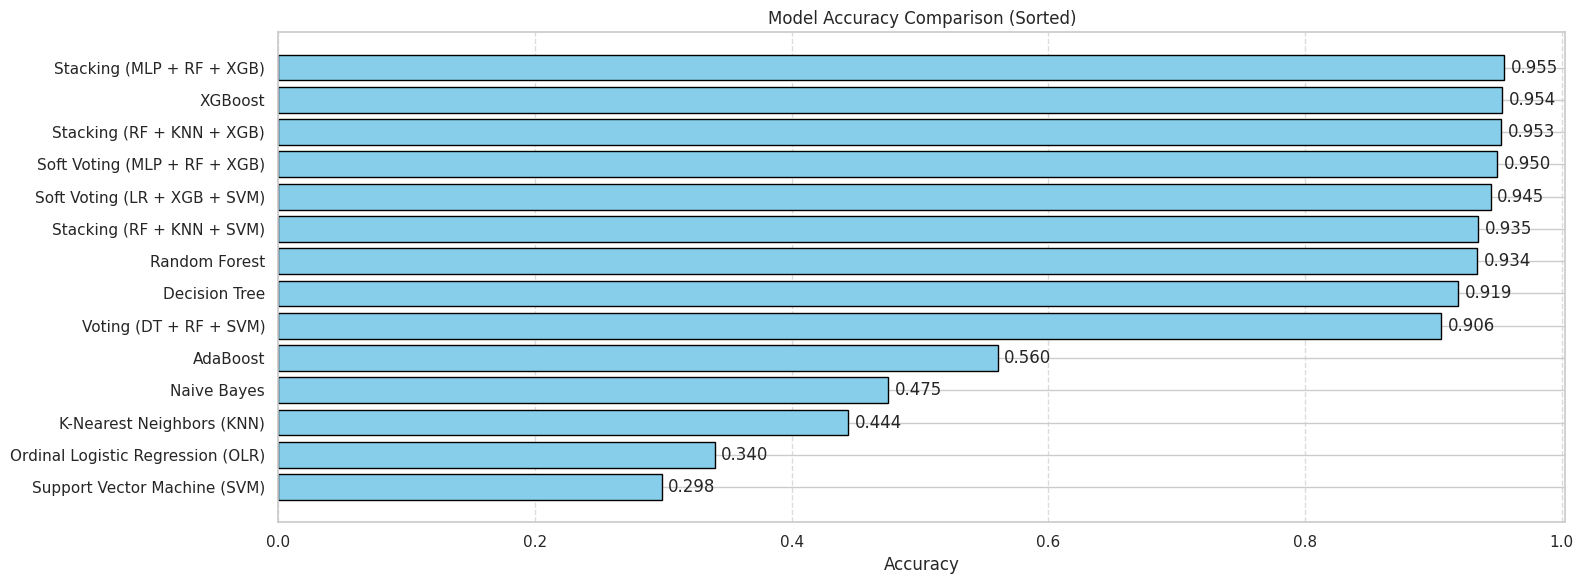

In [ ]:
import matplotlib.pyplot as plt

# List of model names and their corresponding accuracies
model_names = [
    "Ordinal Logistic Regression (OLR)",
    "K-Nearest Neighbors (KNN)",
    "Support Vector Machine (SVM)",
    "Decision Tree",
    "Naive Bayes",
    "Random Forest",
    "AdaBoost",
    "XGBoost",
    "Voting (DT + RF + SVM)",
    "Stacking (RF + KNN + SVM)",
    "Soft Voting (LR + XGB + SVM)",
    "Stacking (RF + KNN + XGB)",
    "Soft Voting (MLP + RF + XGB)",
    "Stacking (MLP + RF + XGB)"
]

# Corresponding accuracy values — replace these with actual results from your models
accuracies = [
    accuracy_score(y_test_encoded, y_pred_olr),         # OLR (encoded target)
    accuracy_score(y_test, y_pred_knn),                 # KNN
    accuracy_score(y_test, y_pred_svm),                 # SVM
    accuracy_score(y_test, y_pred_dt),                  # Decision Tree
    accuracy_score(y_test, y_pred_nb),                  # Naive Bayes
    accuracy_score(y_test, y_pred_rf),                  # Random Forest
    accuracy_score(y_test, y_pred_ada),                 # AdaBoost
    accuracy_score(y_test, y_pred_xgb),                 # XGBoost
    accuracy_score(y_test, y_pred_voting),              # Voting (DT+RF+SVM)
    accuracy_score(y_test, y_pred_stack),               # Stacking (RF+KNN+SVM)
    accuracy_score(y_test, y_pred_soft_voting),         # Soft Voting (LR+XGB+SVM)
    accuracy_score(y_test, y_pred_stacking_xgb),        # Stacking (RF+KNN+XGB)
    accuracy_score(y_test, y_pred_vote),                # Soft Voting (MLP+RF+XGB)
    accuracy_score(y_test, y_pred_stack_mlp)            # Stacking (MLP+RF+XGB)
]

# Sort models by accuracy
sorted_models = sorted(zip(model_names, accuracies), key=lambda x: x[1])
sorted_names = [name for name, acc in sorted_models]
sorted_accuracies = [acc for name, acc in sorted_models]

# Plotting
plt.figure(figsize=(16, 6))
bars = plt.barh(sorted_names, sorted_accuracies, color='skyblue', edgecolor='black')
plt.xlabel("Accuracy")
plt.title("Model Accuracy Comparison (Sorted)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Annotate bars with accuracy values
for bar, acc in zip(bars, sorted_accuracies):
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
             f"{acc:.3f}", va='center')

plt.show()
